In [72]:
import thinkplot
import thinkstats2
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import scipy.stats as ss
import math
import random

##Seaborn for fancy plots. 
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (12,8)

<h1>Estimate a population</h1>

We can keep estimating populations with our analytical distribution. First - we'll do another normal one, but we'll grab some extra data to investigate it a bit more. 

In [73]:
#Simulate Normal - from last time
#
#Add a return to send back the means and the predictions. 
#
def simulateNormal(mu=0, sigma=1, n=100, m=10000, ciLow=5, ciHi=95):
    means = [] #List of all the means that are created. 
    preds = []
    for j in range(m): #Run m number of simulations. 
        xs = np.random.normal(mu, sigma, n) #Generate a normal dist based on emperical data. 
        xbar = np.mean(xs) #Take the mean of the dist above's values
        means.append(xbar) #Add to list. 
        preds.append(xs)
    cdf = thinkstats2.Cdf(means) #Make a CDF of the means of the analytical dist's
    ci = cdf.Percentile(ciLow), cdf.Percentile(ciHi) #5th, 95th percentiles. 
    muList = [mu] * m
    stderr = mean_squared_error(means, muList, squared=False) #RMSE of how different the random analytical means are from the emp. mean. 
    return cdf, ci, stderr, means, preds

We'll add these error calculators, we'll use them later. 

In [74]:
def MeanError(estimates, actual):
    errors = [estimate-actual for estimate in estimates]
    return np.mean(errors)

In [75]:
def RMSE(estimates, actual):
    e2 = [(estimate-actual)**2 for estimate in estimates]
    mse = np.mean(e2)
    return np.sqrt(mse)

<h1>Load Some Income Data</h1>

In [76]:
#Load some data
df = pd.read_csv("data/loan_data.csv")
df.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [77]:
df.describe()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
count,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9.578000e+03,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000
mean,0.804970,0.122640,319.089413,10.932117,12.606679,710.846314,4560.767197,1.691396e+04,46.799236,1.577469,0.163708,0.062122,0.160054
std,0.396245,0.026847,207.071301,0.614813,6.883970,37.970537,2496.930377,3.375619e+04,29.014417,2.200245,0.546215,0.262126,0.366676
min,0.000000,0.060000,15.670000,7.547502,0.000000,612.000000,178.958333,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.103900,163.770000,10.558414,7.212500,682.000000,2820.000000,3.187000e+03,22.600000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.122100,268.950000,10.928884,12.665000,707.000000,4139.958333,8.596000e+03,46.300000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.140700,432.762500,11.291293,17.950000,737.000000,5730.000000,1.824950e+04,70.900000,2.000000,0.000000,0.000000,0.000000
max,1.000000,0.216400,940.140000,14.528354,29.960000,827.000000,17639.958330,1.207359e+06,119.000000,33.000000,13.000000,5.000000,1.000000


<h2>Warmup - Estimate Normal Distribution for Income</h2>

We are given the log.annual.inc, which is the income of the applicants, run through a log transformation. Take a look via a graph...

We can also plot the de-logged, or exponential transformed, income, which should be our orignal incomes. We should double check to see if it makes sense, and to see what it looks like. 

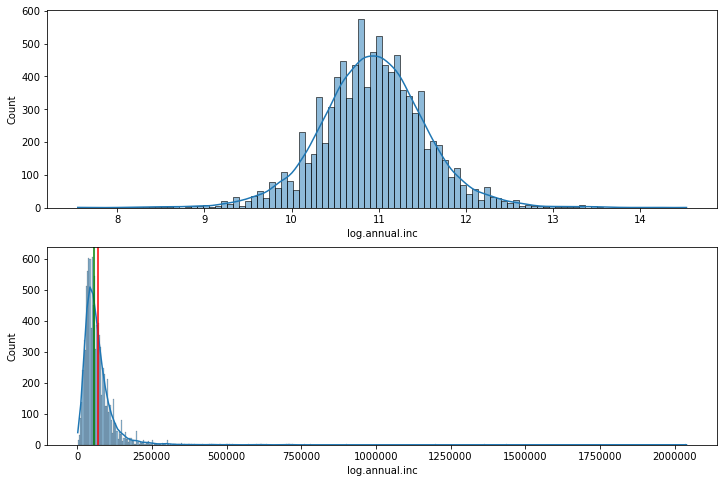

In [82]:
#Graph distribution of log income
thinkplot.PrePlot(2, 2, 1)
sns.histplot(df["log.annual.inc"], kde=True)
thinkplot.SubPlot(2)
sns.histplot(np.exp(df["log.annual.inc"]), kde=True)
plt.axvline(np.mean(np.exp(df["log.annual.inc"])), color="red")
plt.axvline(np.median(np.exp(df["log.annual.inc"])), color="green")
plt.ticklabel_format(style='plain', axis='x')
thinkplot.Config()

<h2>When lognormal is normal!</h2>

The log.annual.inc value looks really normal - estimate the income of the population as a whole. 

<b>Note:</b> this data is the income data, that has been transformed, with a log transformation. This is one example of some ways that we can use a transformation to make analysis easier. Transform the data into somehting that is easy to analyze, like a normal dist, do what you need to do, then transform in reverse to get raw data. 

The original distribution above could be analyzed directly via modelling it with a lognorm distribution, like we'll try below, but normal things are generally more simple, that's why this data was pretransformed. 

Work with the data (already logged):

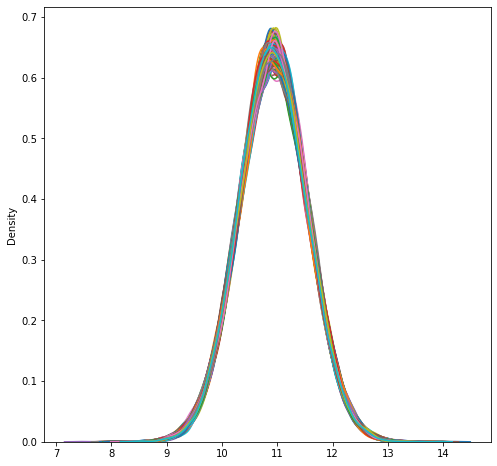

In [ ]:
#Generate estimators for normal data. 
mu = df["log.annual.inc"].mean()
sig = df["log.annual.inc"].std()
n = df["log.annual.inc"].count()

#Run Estimations. 
cdf, ci, stderr, means, preds = simulateNormal(mu=mu, sigma=sig, n=n, m=1000, ciLow=5, ciHi=95)

#Graph each of those predictions from above - 1000 originally. 
for i in range(len(preds)):
    sns.kdeplot(preds[i])

#### What's This?

Each of those trial runs of the analytical distribution is slightly different, as we can see here. 

#### CDF of the Means

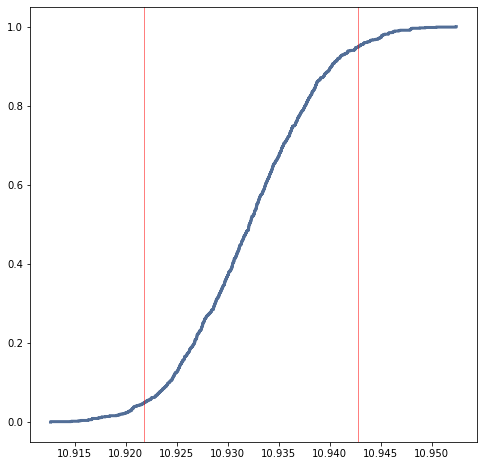

In [ ]:
thinkplot.Cdf(cdf)
thinkplot.axvline(ci[0], color="red")
thinkplot.axvline(ci[1], color="red")

#### Overall

Each random band up there is one prediction of the distribution of the population of income. I.E. each one is one execution of the "random" command that generates N variables according to the distribution. 

The means is taking the average of all of those above predicted distributions, then averaging them together. So that is estimating the mean of the population of income M times, graphed below.  

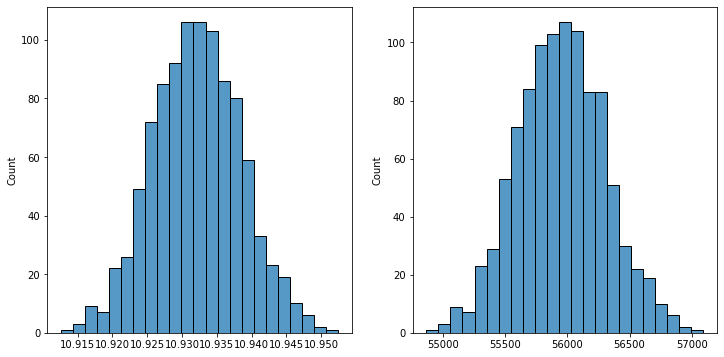

In [ ]:
#Plot the means of the above distributions
#sns.kdeplot(means, linestyle="dotted")
thinkplot.PrePlot(2,1,2)
sns.histplot(means)
thinkplot.SubPlot(2)
sns.histplot(np.exp(means))
thinkplot.Config()

In [ ]:
#Is the estimator biased? - Check to see that the mean of the predictions is close to the emperical mean. 
m=10000
estimates = []
for i in range(m):
    L = np.random.normal(mu, sig, n)
    estimates.append(L)
print('Experiment:')
print('rmse', RMSE(estimates, mu))
print('mean error', MeanError(estimates, mu))

Experiment:
rmse 0.6147843351903066
mean error -7.171562834621105e-06


<b>Estimator does not look biased, the mean error appears to trend near 0</b><br><br><br>
Above is the distribution of the means of the predictions above. So each of those lines up there is a value that's being counted up to make this histogram.


We currently have a log transformed set of data. What if we want to see the real values along with our estimate. 

Estimated Population Mean: 55946.66124060392


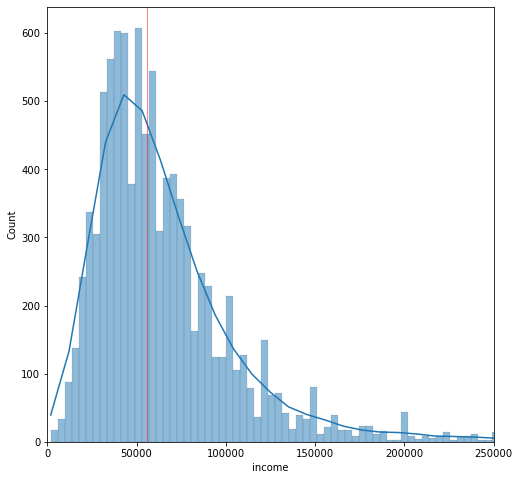

In [ ]:
#Visualize as original data. Limit graph to $250k to make it look OK
df["income"] = np.exp(df["log.annual.inc"])
#sns.kdeplot(df["income"], clip=(0,250000))
sns.histplot(df["income"], kde=True)
plt.xlim(0,250000)

convMed = np.exp(np.mean(means))
thinkplot.axvline(convMed, color="red")
print("Estimated Population Mean:", convMed)

## Discreet Distributions

Until now, we've mainly dealt with distributions like the normal, lognormal, and exponential - distributions that are continuous, or they may take on any value. We also have distributions that measure discreet things - things which may only take on specific values. Two examples below are goals in sports (hockey, soccer, etc...) or votes in an election - each of these things are counted via whole numbers. 

As we mentioned before, no matter the disribution we create, the process is pretty much the same. (I found this image online, and I think it is a good illustration. This is over-the-top detailed for us, it shows two standard deviations for normal on each side of the curve, but it does a reasonable job of illustrating what we need.)

![Distributions](images/distributions.png "Distributions")

### Goals in a Game

We can approximate the expected number of goals in a game by using a Poisson distribution. It is use to model things that happen periodically, but semi-randomly - like customrers walking into a store, phone calls to a call center, or goals in some game. 
<br><br>
Below are a couple of examples - the input is the rate - in this case goals per game. It could be "calls per hour" or similar....

<AxesSubplot:ylabel='Density'>

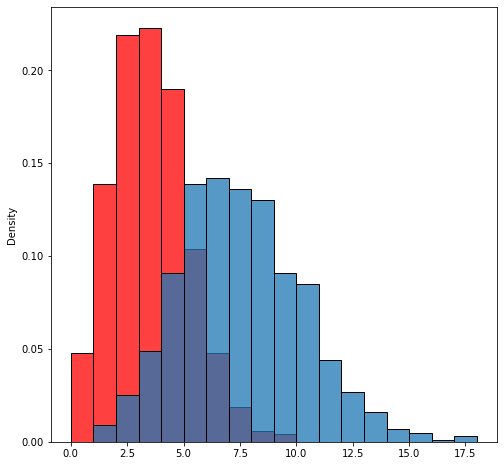

In [ ]:
#Example poisson distributions
dist = ss.poisson(3)
dist2 = ss.poisson(7)

sns.histplot(dist.rvs(1000), binwidth=1, stat="density", color="red")
sns.histplot(dist2.rvs(1000), binwidth=1, stat="density")

<h2>Application - Forecast Games</h2>

We can apply this to do a simple estimation of the Battle of Alberta. 

<h3>Load some data</h3>

We can load some data on hockey!

In [ ]:
#Load and preview data
hock = pd.read_excel("data/sportsref_download.xlsx", sheet_name="Worksheet", engine="openpyxl", header=1)
hock.head()

,Rk,Unnamed: 1,AvAge,GP,W,L,OL,PTS,PTS%,GF,...,PK%,SH,SHA,PIM/G,oPIM/G,S,S%,SA,SV%,SO
0,1.0,Florida Panthers,27.5,6,6,0,0,12,1.000,27,...,85.19,1,1,10.8,11.8,210,12.9,189,0.937,0
1,2.0,Carolina Hurricanes,27.9,5,5,0,0,10,1.000,22,...,90.00,0,0,8.0,8.0,175,12.6,149,0.946,0
2,3.0,Edmonton Oilers,29.4,5,5,0,0,10,1.000,23,...,88.24,1,0,13.0,8.6,168,13.7,188,0.931,0
3,4.0,St. Louis Blues,28.8,5,5,0,0,10,1.000,25,...,93.75,1,0,9.0,10.2,174,14.4,170,0.935,1
4,5.0,Minnesota Wild,29.4,6,5,1,0,10,0.833,20,...,69.23,0,0,13.3,12.0,218,9.2,167,0.892,0


In [ ]:
#Rename column for teams
hock = hock.rename(columns={'Unnamed: 1':"Team"})

In [ ]:
#Find the GOALS PER GAME column - It will be very close to GF/G, but we need to be sure!!
hock.columns

Index(['Rk', 'Team', 'AvAge', 'GP', 'W', 'L', 'OL', 'PTS', 'PTS%', 'GF', 'GA',
       'SOW', 'SOL', 'SRS', 'SOS', 'GF/G', 'GA/G', 'PP', 'PPO', 'PP%', 'PPA',
       'PPOA', 'PK%', 'SH', 'SHA', 'PIM/G', 'oPIM/G', 'S', 'S%', 'SA', 'SV%',
       'SO'],
      dtype='object')

In [ ]:
#Get Goals per game for the teams playing.
Oil = hock[hock["Team"]=="Edmonton Oilers"]
gfOil = Oil["GF/G"]
print("Oilers Goals per Game:", gfOil)
Fla = hock[hock["Team"]=="Calgary Flames"]
gfFla = Fla["GF/G"]
print("Falmes Goals per Game:", gfFla)

Oilers Goals per Game: 2    4.6
Name: GF/G, dtype: float64
Falmes Goals per Game: 7    3.5
Name: GF/G, dtype: float64


Simulate one game - take the goals per game, and generate one prediction of an outcome in terms of goals. 

In [ ]:
def SimGame(lam):
    dist = ss.poisson(lam)
    score = dist.rvs(1)
    return score[0]

Simulate a bunch of games, and check for bias in our estimator. 

In [ ]:
def estimateGame(lam=2., m=1000):
    estimates = []
    for i in range(m):
        L = SimGame(lam)
        estimates.append(L)

    print('Goal Distribution:')
    print('rmse Goals:', RMSE(estimates, lam))
    print('mean error Goals:', MeanError(estimates, lam))
    
    pmf = thinkstats2.Pmf(estimates)
    thinkplot.Hist(pmf)
    thinkplot.Config(xlabel='Goals scored', ylabel='PMF')

Goal Distribution:
rmse Goals: 2.192970588038061
mean error Goals: 0.01540000000000033


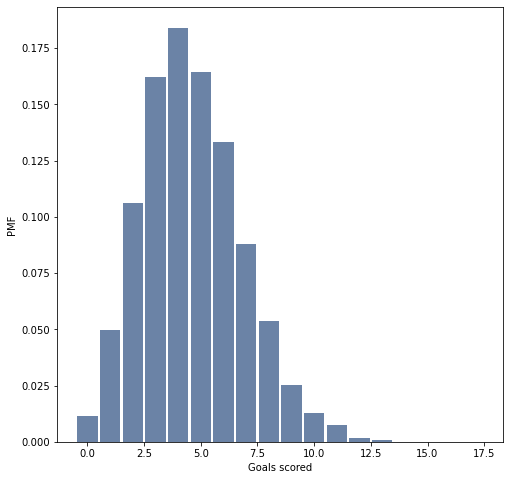

In [ ]:
estimateGame(gfOil, 10000)

In [ ]:
#Estimate a bunch of games, count how many one team wins vs the other. 
def estimateMatch(team1=1, team2=1, m=1000):
    team1Wins = []
    for i in range(m):
        goal1 = SimGame(team1)
        goal2 = SimGame(team2)
        team1Wins.append(int(goal1>goal2))
    return team1Wins

In [ ]:
np.mean(estimateMatch(gfOil,gfFla,1000))

0.596

## Polling! 

Suppose we are trying to estimate who would win the previous presidental election in the US - in Arizona. 

<b>Note:</b> Estimating the overall win would require projecting each state individually (and dealing with Nebraska and Maine), then projecting the total electoral college votes, since in a presidential election they are effectively separate elections. Same deal, more complex model. Canada is also more complex, since you'd need to project each house seat individually in 4ish way race, then project the distribution of seats, etc... same idea, way more complex scenario. In each of these scenarios winning the most votes doesn't translate into the overall win - winning the most votes, the most times, in multiple smaller elections translates into an overall win. 

In real applications there's also an expectation of correlation between different elections - e.g. it is unlikely for the NDP to win all provincial ridings in west Edmonton, and lose all those in east Edmonton - there is some expected correlation that factors into overall predictions. Voter turnout also is factored in - lower turnouts tend to correspond to more conservative winners - hence the voter supression. There's also the expected sample bias, I'm an old millenial without a land line, and I don't know of any of my social circle who has ever been part of a political poll; the polling organizations know they aren't getting a perfectly representative samples so they build in corrections to their projections to correct for that. Actual polling organizations have factors like these, and others, built into their actual predictions, and this is an example of where their knowledge and skills differentiate their predictions. 

Having no idea how polls work has been one illustration of stats impacting the real world recently. Polls can of course "be wrong" and certain polling organizations generate biased projections, but much more often they are predicting things with a large amount of uncertainty and the less likely thing just happens. Even a poll that says something has an ~97% likelihood of happening is saying that the opposite will happen about one out of every 36 times - unlikely yes, but hardly a total shock - equivalent to rolling snake eyes (two dice, both ones) in a game of craps, which does happen, all the time, just ask Vegas. Legitimate polling organizations publish their confidence intervals and some sampling data at a minimum, and may share some of their interal modelling assumptions, though that is part of what makes them 'better' than their competitors, so they may not give it all. Check this document: [Polling Methodology](guides/polling_report.pdf) the Methodology section towards the end offers a good explaination of how they went about their work in executing the poll and processing the data. Media reports tend to be a very, very short summary of the real results - often to the point of removing needed context. 

<h2>First - Establish probability an individual vote goes for Biden or Trump. </h2>

From 538: https://projects.fivethirtyeight.com/polls/president-general/arizona/ we can estimate basssed on all the previous polls that a person is approximately 49% likely to vote Biden, and 46% likely to vote Trump. 

Note: What 538 does to get these numbers involves some estimation already. They take multiple polls and attempt to combine them to make as accurate an estimate as possible. They try to correct for polling companies that historically skew Dem, or skew Rep, or tend to be more/less accurate. We could do this with one poll, it would be the same. 

Because we know (from experience) that only one of these two will actually win, we can try to isolate the share of votes of people who vote for one of these two - 3rd part votes are irrelevant. In reality, one of the things that pollsters will do is try to estimate the number of people who poll that they will vote 3rd party, then end up voting for Trump/Biden. This is an estimate they make based on past data, and domain knowledge. E.g. if we estimated that the share of 3rd party poll responses that voted T/B was skewed 2:1 towards Trump (e.g. libritarians voting Republican), we would add an adjustment here based on that knowledge. Maybe we'd add 1% to Biden's vote probability, and 2% to Trump's. This is something that really is an assumption though. These adjustments based on assumed human actions is what makes a really skilled pollster more accurate - they all know how to do the math. 

We can also phrase this in a Bayes table - the prior is the orignal poll values, we get the info that only 95% of voters will vote for one of those two, that updates our knowledge. The calc is pretty simple though, we don't need that...

In [ ]:
#How likely is it for someone to vote Trump and Biden?
probT = .46/(.49+.46)
print("Trump Prob:", probT)

probB = .49/(.49+.46)
print("Biden Prob:", probB)

Trump Prob: 0.48421052631578954
Biden Prob: 0.5157894736842106


So, of the votes that will matter, about 51.5% go Biden, 48.5% go Trump. How does this translate to a person making a vote. For each person, we can make a function to basically get one response. 

This person will return one vote. It will be either a vote for Trump or for Biden. That decision will be random, but it will be set with a likelihood that we calculated before - apx 51.5% of the total voters will vote Biden, as the number of votes we collect gets large. 

Note: for the example, we'll use a vote for Biden to be True/1. A vote for Trump is False/0. This is arbitrary. 

Below we have a function to generate a prediciton using a BINOMIAL distribution - it is either 1 or 0. (A 1 sample binomial dist is also called a Bernouli)

In [ ]:
#Generate one vote, with a likelihood supplied as an argument. 
def oneVote(probCalc):
    vote = np.random.binomial(n=1, p=probCalc)
    return vote

In [ ]:
#Get one vote, is it Biden or not?
#Run the cell a bunch of times to repeat. 
oneVote(probB)

0

OK, now we have our fake voter. One vote isn't good enough, we need to sample a bunch of people. 

Below, generate a list of n predicted voters. Then check the number that voted Biden. 

In [ ]:
#Get an arbitrary number of simulated votes
def getSample(voteProb, n=1000):
    vote_list = []
    for i in range(n):
        vote_list.append(oneVote(voteProb))
    return vote_list

In [ ]:
#Get a bunch of votes, print the percentage that are Biden. 
#Try changing n and see what happens. 
tmp = getSample(probB, 500000)
np.mean(tmp)

0.51655

That allows us to make one simulation. Congrats - that thing above is one simulated election
<br><br>

We should take a bunch though, and average their results together. 

In [ ]:
def getSamples(voteProb, n=1000, samples=100, ciLow=2.5, ciHi=97.5):
    meanList = []
    for i in range(samples):
        meanList.append(np.mean(getSample(voteProb, n)))
    muList = [voteProb] * samples
    cdf = thinkstats2.Cdf(meanList) #Make a CDF of the means of the analytical dist's
    ci = cdf.Percentile(ciLow), cdf.Percentile(ciHi) #5th, 95th percentiles. 
    stderr = mean_squared_error(meanList, muList, squared=False)
    return meanList, stderr, cdf, ci

In [ ]:
getSamples(probB, 1000, 5)

([0.53, 0.538, 0.508, 0.525, 0.525],
 0.013605807787124065,
 Cdf([0.508 0.525 0.53  0.538], [0.2 0.6 0.8 1. ]),
 (0.508, 0.538))

Error: 0.16227605493584124
Error: 0.050326221116391755
Error: 0.016679047848097144
Error: 0.004657177851463927
Error: 0.0016669918741815382


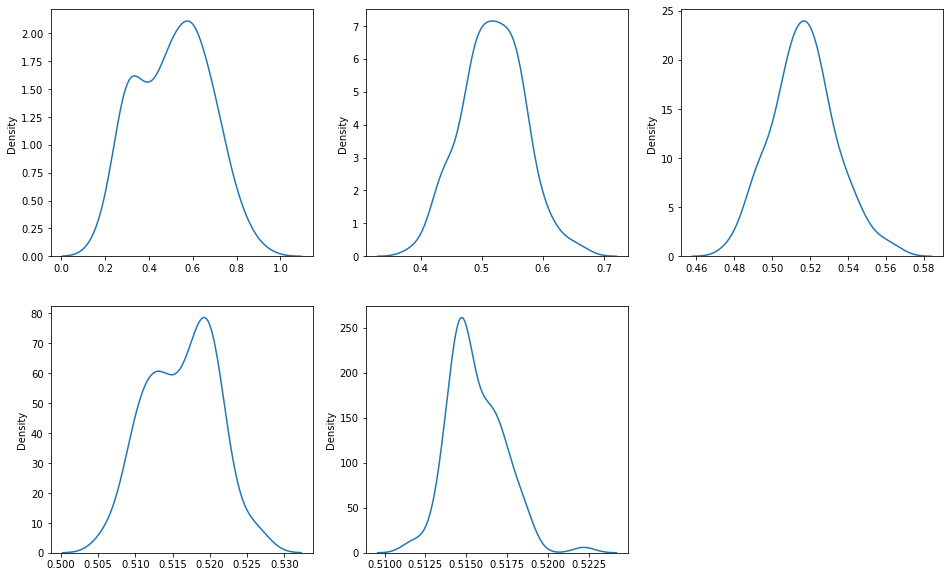

In [ ]:
#Print a grid of differnet n values

countHist = 5
nVals = [10,100,1000,10000,100000,1000000]
thinkplot.PrePlot(6,rows=2,cols=3)
samples = 100

for i in range(countHist):
    tmpH, err, cdf, ci = getSamples(probB, nVals[i], samples)
    thinkplot.SubPlot(i+1)
    sns.kdeplot(tmpH)
    print("Error:", err)
thinkplot.Config()

Error: 0.1578701735279679
Error: 0.05210709725639622
Error: 0.014858228457948396
Error: 0.004743480874139173
Error: 0.0016168162552758151


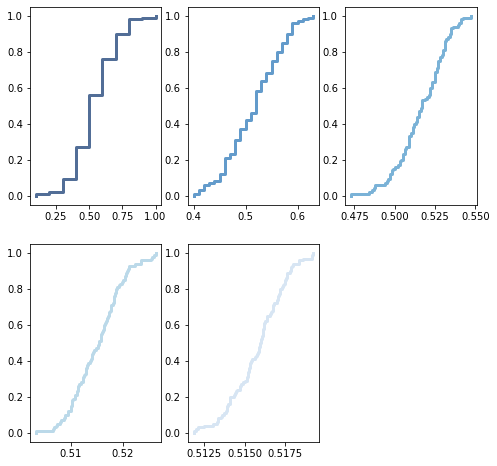

In [ ]:
#And the CDFs
for i in range(countHist):
    tmpH, err, cdf, ci = getSamples(probB, nVals[i], samples)
    thinkplot.SubPlot(i+1)
    thinkplot.Cdf(cdf)
    print("Error:", err)
thinkplot.Config()

Above are multiple executions, with multiple n values. What we should see is that as we get larger and larger n values - the number of 'surveys' taken, we should get closer and closer to a normal curve centered around the expected percentage of votes for Biden = 51.5%. 

<h2>Predict the Winner!!!!</h2>
Now we can calculate our projections!

We don't really want to know what percentage of votes Biden is going to get, we want to know how likely he is to win. 

<br><br><br>
What we can do below is run some simulations, and for each one see if Biden wins, or if he looses, and then count them up. 

0.772


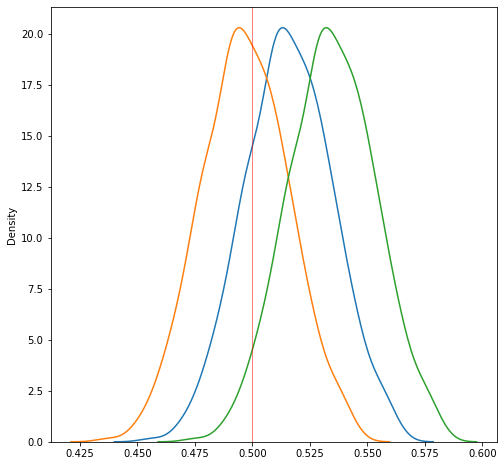

In [ ]:
#Run a bunch of trials and count how many Biden wins in. 
trials = 1000
means, err, cdfFin, ciFin = getSamples(probB, n=700, samples=trials)
lowest = means - err
highest = means + err
bWins = 0 
for i in range(len(means)):
    if means[i] > .5000:
        bWins = bWins + 1
print(bWins/trials)

sns.kdeplot(means)
sns.kdeplot(lowest)
sns.kdeplot(highest)
thinkplot.axvline(.5, color="red")

Fraction of Scenarios where Biden wins 0.772


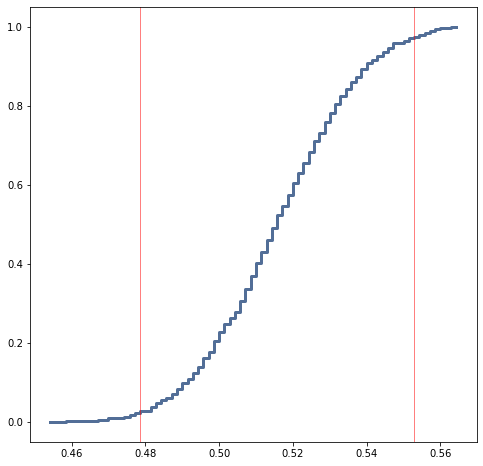

In [ ]:
thinkplot.Cdf(cdfFin)
thinkplot.axvline(ciFin[0], color="red")
thinkplot.axvline(ciFin[1], color="red")
print("Fraction of Scenarios where Biden wins", 1-cdfFin.Prob(.50))